In [1]:
import torch
import torchvision
from torchvision import transforms ,models
import os
from torch.utils.data.dataset import Dataset
from glob import glob as glob

In [4]:
import pickle 
with open ( '../dataset/combined_annotations_processed.pkl' , 'rb') as f:
    anno_train_json = pickle.load(f)

In [3]:
class SVHNTEST(Dataset):
    def __init__(self, phase, anno_file ,augment):
        self.transforms = augment
        self.anno_file = anno_file
        self.phase = phase
        if phase == 'train':
            self.img_paths = glob('../dataset/coco_format_combined/train/*')
        if phase == 'val':
            self.img_paths = glob('../svhn/coco_format_combined/val/*')
        if phase == 'test':
            self.img_paths = glob('../testsvhn//*')
        self.dataset_size = len(self.img_paths)
        
            

    def __getitem__(self, index):

        A_path = self.img_paths[index]
        A_image = Image.open(A_path)
        A_image_transformed = self.transforms(A_image)
        
        if self.phase == 'train' or self.phase == 'val':
            A_label_org = self.anno_file[os.path.basename(A_path)]['label']
            A_lable_final = torch.zeros(10)
            for i in A_label_org:
                A_lable_final[i] = 1
            A_lable_final = torch.tensor(A_lable_final)

            return A_image_transformed,A_lable_final
        
        if self.phase == 'test':
            return A_image_transformed

    def __len__(self):
        return self.dataset_size

    def name(self):
        return 'SVHNTEST'

In [4]:
from torchvision import transforms
from PIL import Image
augment = {}
augment['1'] = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),
#     transforms.RandomResizedCrop(64),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])  # change to [C, H, W]
augment['2'] = transforms.Compose([
    transforms.Resize((64, 64), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])  # change to [C, H, W]

In [5]:
train_dataset = SVHNTEST('train',anno_train_json,augment['1'])
val_dataset = SVHNTEST('val',anno_train_json,augment['2'])
train_dataset[10][0]

<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

label for the image  torch.Size([3, 64, 64]) tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


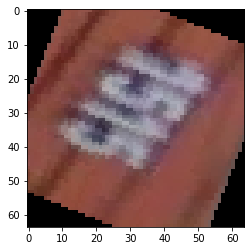

In [6]:
from PIL import Image
from matplotlib import pyplot as plt
import random
check_random_image = random.randint(0,len(train_dataset))

image_numpy = train_dataset[check_random_image][0].cpu().float().numpy()
image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
plt.imshow(Image.fromarray(np.array(image_numpy,dtype=np.uint8)))
print('label for the image ', train_dataset[check_random_image][0].shape,train_dataset[check_random_image][1])

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=1,
                             pin_memory=True,
                             drop_last = True)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1,
                             pin_memory=True,
                             drop_last = True)
dataloaders = {
    'train':train_dataloader,
    'val':val_dataloader
}


In [8]:
for i,x in train_dataloader:
    print(i.shape,x.shape)
    break

<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


torch.Size([128, 3, 64, 64]) torch.Size([128, 10])


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = F.sigmoid(outputs)
                    preds = outputs
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += pred_acc(labels.cpu(),outputs.cpu())
            if phase == 'train':
                scheduler.step()
            if phase == 'train':
                dataset_sizes = len(train_dataset)
            if  phase == 'val':
                dataset_sizes = len(val_dataset)
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects / dataset_sizes

            print('{} Loss: {:.4f} ACC {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()
        torch.save(model,f'./output_model/{epoch}.pth')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # save the model after every epoch

    return model

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy 

import torch.nn.functional as F

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.BCELoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/original.size()[-1]

In [13]:
model = model.to(device)

In [14]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)
/home/deep/.virtualenvs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 0.5356 ACC 0.7644


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5325 ACC 0.7648

Epoch 1/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5313 ACC 0.7652


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5303 ACC 0.7650

Epoch 2/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5282 ACC 0.7652


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5279 ACC 0.7651

Epoch 3/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5251 ACC 0.7655


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5251 ACC 0.7653

Epoch 4/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5227 ACC 0.7661


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5228 ACC 0.7658

Epoch 5/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5207 ACC 0.7666


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5209 ACC 0.7661

Epoch 6/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5189 ACC 0.7673


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5191 ACC 0.7666

Epoch 7/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5175 ACC 0.7677


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5185 ACC 0.7666

Epoch 8/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5170 ACC 0.7678


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5181 ACC 0.7667

Epoch 9/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5167 ACC 0.7679


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5179 ACC 0.7667

Epoch 10/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5165 ACC 0.7680


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5177 ACC 0.7667

Epoch 11/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5160 ACC 0.7682


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5174 ACC 0.7668

Epoch 12/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5157 ACC 0.7683


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5170 ACC 0.7670

Epoch 13/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5155 ACC 0.7684


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5168 ACC 0.7672

Epoch 14/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5153 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7672

Epoch 15/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5153 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5167 ACC 0.7672

Epoch 16/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5152 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5167 ACC 0.7673

Epoch 17/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5151 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7673

Epoch 18/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7673

Epoch 19/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7673

Epoch 20/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5151 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 21/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5151 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 22/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 23/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 24/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7672

Epoch 25/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 26/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 27/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 28/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5151 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7672

Epoch 29/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 30/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7673

Epoch 31/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 32/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 33/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5151 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7672

Epoch 34/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5148 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 35/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7674

Epoch 36/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 37/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7672

Epoch 38/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5166 ACC 0.7673

Epoch 39/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 40/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 41/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 42/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 43/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 44/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 45/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7672

Epoch 46/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5164 ACC 0.7672

Epoch 47/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5149 ACC 0.7685


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Epoch 48/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5148 ACC 0.7686


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7674

Epoch 49/49
----------


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


train Loss: 0.5150 ACC 0.7687


<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


val Loss: 0.5165 ACC 0.7673

Training complete in 136m 29s
Best val Acc: 0.767372


In [28]:
# Test the Model

model = torch.load('./good_result/output_model_fulldata_pretrain/29.pth')
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
inputs, labels = next(iter(dataloaders['val']))
with torch.no_grad():    
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = F.sigmoid(model(inputs))

<ipython-input-3-cd363cb55107>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_lable_final = torch.tensor(A_lable_final)


tensor([0.0847, 0.3691, 0.5503, 0.3132, 0.4021, 0.1757, 0.2489, 0.1932, 0.1123,
        0.1595], device='cuda:0') tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


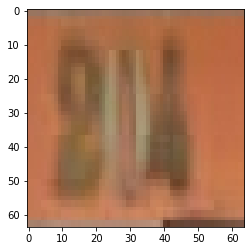

In [30]:
index = random.randint(0,len(labels))
image_numpy = inputs[index].cpu().float().numpy()
image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
plt.imshow(Image.fromarray(np.array(image_numpy,dtype=np.uint8)))
print(outputs[index],labels[index])

In [31]:
index = random.randint(0,BATCH_SIZE)
test_dataset = SVHNTEST('test',anno_train_json,augment['2'])

In [32]:
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1,
                             pin_memory=True,
                             drop_last = True)
inputs = next(iter(test_dataloader))
with torch.no_grad():    
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = F.sigmoid(model(inputs))

tensor([0.0351, 0.5715, 0.2703, 0.1686, 0.1941, 0.1602, 0.1410, 0.2710, 0.1388,
        0.1034], device='cuda:0')


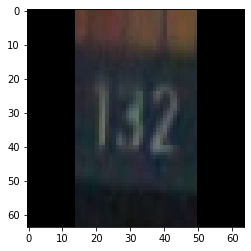

In [36]:
index = random.randint(0,31)
image_numpy = inputs[index].cpu().float().numpy()
image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
plt.imshow(Image.fromarray(np.array(image_numpy,dtype=np.uint8)))
print(outputs[index])